

### COVID 19 DETECTION USING CT SCAN IMAGES USING SELF-SUPERVISED LEARNING



1. IMPORTING PACKAGES

In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from google.colab import drive
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torchvision import datasets, transforms
import random
from PIL import Image
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18
from torch.cuda.amp import autocast, GradScaler
from torch.optim import Adam

2A. MOUNT GOOGLE DRIVE AND IMPORT THE IMAGES REQUIRED

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Path to the CT folder in your Google Drive
data_dir = '/content/drive/My Drive/CT'

# Folders for COVID and Non-COVID images
covid_dir = os.path.join(data_dir, 'COVID')
non_covid_dir = os.path.join(data_dir, 'non-COVID')

# Get a list of image paths for COVID and Non-COVID images
covid_image_paths = [os.path.join(covid_dir, img) for img in os.listdir(covid_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]
non_covid_image_paths = [os.path.join(non_covid_dir, img) for img in os.listdir(non_covid_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]

2B. PRINT SOME SAMPLE IMAGES

Sample COVID Images:


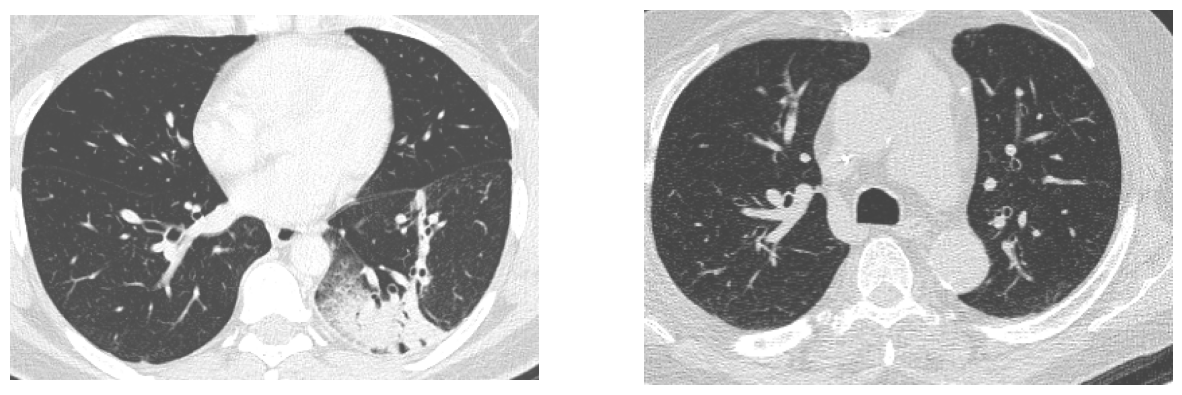

Sample Non-COVID Images:


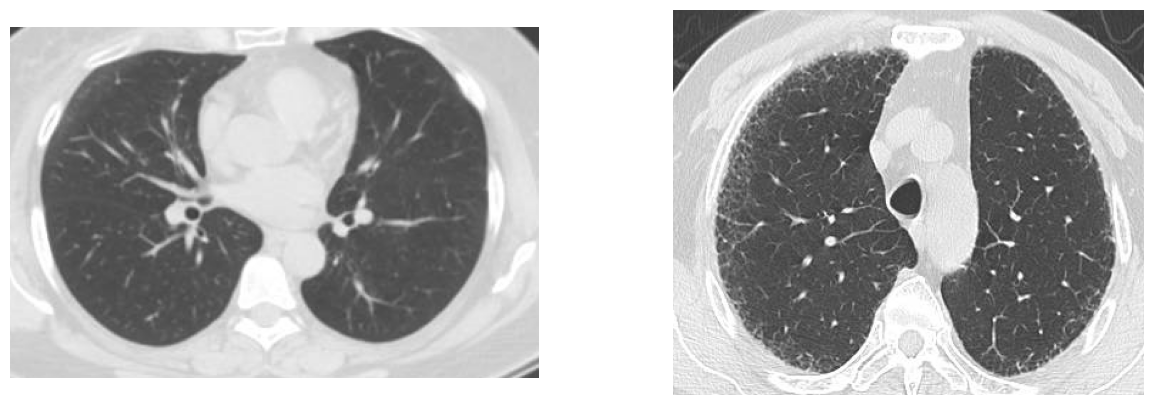

In [4]:
# Function to display images
def display_images(image_paths, num_images=2):
  plt.figure(figsize=(15, 5))
  for i in range(min(num_images, len(image_paths))):
    img = Image.open(image_paths[i])
    plt.subplot(1, num_images, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  plt.show()


# Display some COVID images
print("Sample COVID Images:")
display_images(covid_image_paths)

# Display some Non-COVID images
print("Sample Non-COVID Images:")
display_images(non_covid_image_paths)

3. PERFORMING AUGMENTATIONS TO IMAGES

In [6]:
aug_pipe=T.Compose([
    T.RandomChoice([
        T.RandomHorizontalFlip(p=1),
        T.ColorJitter(brightness=0.2, contrast=0.2),
        T.RandomRotation(degrees=10),
        T.RandomAffine(degrees=5, translate=(0.01, 0.01), scale=(1.0, 1.05)),

    ]),
    T.Resize((512,512)),

    T.ToTensor()
])

3B. TESTING PIPELINE ON A SAMPLE IMAGE

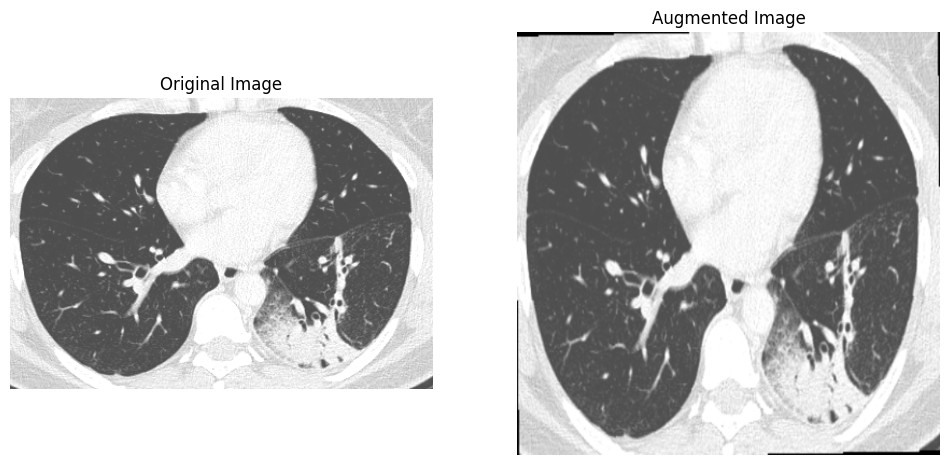

In [7]:
image = Image.open(covid_image_paths[0])

# Apply augmentations to the image
augmented_image = aug_pipe(image)
augmented_image_pil = T.ToPILImage()(augmented_image)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# original image
ax[0].imshow(image)
ax[0].set_title('Original Image')
ax[0].axis('off')
# augmented image
ax[1].imshow(augmented_image_pil)
ax[1].set_title('Augmented Image')
ax[1].axis('off')
plt.show()

4A. CREATING CUSTOM DATSET

In [8]:
class CTDataset(Dataset):
  def __init__(self, img_dir1, img_dir2, transform=None):
    self.img_dir1 = img_dir1
    self.img_dir2 = img_dir2
    self.transform = transform
    self.image_files1 = [f for f in os.listdir(img_dir1) if os.path.isfile(os.path.join(img_dir1, f))]
    self.image_files2 = [os.path.join(img_dir2, f) for f in os.listdir(img_dir2) if os.path.isfile(os.path.join(img_dir2, f))]
    self.all_image_files = self.image_files1 + self.image_files2

  def __len__(self):
    return len(self.all_image_files)

  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir1, self.all_image_files[idx])
    img = Image.open(img_path).convert('L')
    img1 = img.copy()
    img2 = img.copy()
    if self.transform:
      img1 = self.transform(img1)
      img2 = self.transform(img2)

    return img1, img2

4B. CREATE DATA LOADERS

In [9]:
dataset=CTDataset(covid_dir, non_covid_dir, aug_pipe)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)

5. DEFINT THE BYOL MODEL TO TRAIN THE NETWORK

In [10]:
#Projection Head for BYOL model
class ProjectionHead(nn.Module):
  def __init__(self, input_dim=512, hidden_dim=512, output_dim=128):
    super().__init__()
    self.l1=nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.BatchNorm1d(hidden_dim),
        nn.ReLU(),
    )
    self.l2=nn.Sequential(
        nn.Linear(hidden_dim, hidden_dim),
        nn.BatchNorm1d(hidden_dim),
    )
  def forward(self, x):
    x=self.l1(x)
    x=self.l2(x)
    return F.normalize(x, dim=1)


In [11]:
class BYOL(nn.Module):
    def __init__(self):
        super().__init__()

        # Online encoder
        self.encoder = resnet18(pretrained=False)
        # Modify first conv layer for single-channel input
        self.encoder.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7),
                                     stride=(2, 2), padding=(3, 3), bias=False)
        self.encoder.fc = nn.Identity()

        # Online projection head
        self.projection_head = ProjectionHead(512)

        # Target encoder
        self.target_encoder = resnet18(pretrained=False)
        self.target_encoder.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7),
                                            stride=(2, 2), padding=(3, 3), bias=False)
        self.target_encoder.fc = nn.Identity()

        # Target projection head
        self.target_projection_head = ProjectionHead(512)

        # Initialize target network with online network parameters
        self._init_target_network()

    def _init_target_network(self):
        """Initialize target network with online network parameters"""
        for param_online, param_target in zip(self.encoder.parameters(),
                                            self.target_encoder.parameters()):
            param_target.data.copy_(param_online.data)
            param_target.requires_grad = False

        for param_online, param_target in zip(self.projection_head.parameters(),
                                            self.target_projection_head.parameters()):
            param_target.data.copy_(param_online.data)
            param_target.requires_grad = False

    def target_update(self, tau=0.996):
        """Update target network parameters using exponential moving average"""
        # Update encoder
        for param_online, param_target in zip(self.encoder.parameters(),
                                            self.target_encoder.parameters()):
            param_target.data = tau * param_target.data + (1 - tau) * param_online.data

        # Update projection head
        for param_online, param_target in zip(self.projection_head.parameters(),
                                            self.target_projection_head.parameters()):
            param_target.data = tau * param_target.data + (1 - tau) * param_online.data

    def forward(self, x):
        # Get online network representations
        online_proj = self.projection_head(self.encoder(x))

        # Get target network representations (no gradient)
        with torch.no_grad():
            target_proj = self.target_projection_head(self.target_encoder(x))

        return online_proj, target_proj

    def loss_fn(self, online_proj, target_proj):
        """Compute BYOL's loss function"""
        # Normalize projections
        online_proj = nn.functional.normalize(online_proj, dim=-1)
        target_proj = nn.functional.normalize(target_proj, dim=-1)

        # Negative cosine similarity (with proper normalization)
        return 2 - 2 * (online_proj * target_proj).sum(dim=-1).mean()

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
byol = BYOL().to(device)
#Defining optimizer
optimizer = torch.optim.Adam(byol.parameters(), lr=1e-3, weight_decay=1e-5)
#Defining scaler
scaler=GradScaler()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-16-c5a13ddf544c>:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler=GradScaler()


6. MODEL TRAINING

In [13]:
#PATH TO SAVE MODEL AFTER CHECKPOINTS
os.makedirs(data_dir, exist_ok=True)

In [ ]:
checkpoint = torch.load(os.path.join(data_dir,'checkpoint_epoch_4_batch_61.pt'))
model_state_dict = checkpoint['model_state_dict']  # Model's state dictionary (weights)
optimizer_state_dict = checkpoint['optimizer_state_dict']  # Optimizer's state dictionary
loss = checkpoint['loss']
byol = BYOL().to(device)  # Replace with the actual model class definition
byol.load_state_dict(model_state_dict)
optimizer.load_state_dict(optimizer_state_dict)


<ipython-input-10-14206ab24cc1>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(data_dir,'checkpoint_epoch_4_batch_61.pt'))


In [17]:
torch.cuda.empty_cache()
scaler = torch.cuda.amp.GradScaler(enabled=True)

# Early stopping parameters (batch-level)
check_every = 20  # Check every 20 batches
patience_batches = 3  # Number of checks with no improvement before stopping
best_batch_loss = float('inf')
patience_counter = 0

# Training loop with batch-level early stopping
num_ep = 10
for epoch in range(num_ep):
    byol.train()
    batch_loss_sum = 0.0

    for batch_idx, (imgs, _) in enumerate(train_loader):
        imgs = imgs.to(device)
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with autocast
        with torch.cuda.amp.autocast():
            online_pred1, target_proj2 = byol(imgs)
            online_pred2, target_proj1 = byol(imgs)
            loss = byol.loss_fn(online_pred1, target_proj2) + byol.loss_fn(online_pred2, target_proj1)

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(byol.parameters(), max_norm=1.0)  # Gradient clipping

        optimizer.step()  # Update parameters
        byol.target_update()  # Update BYOL target network

        batch_loss_sum += loss.item()  # Accumulate batch loss

        if batch_idx % 10 == 0:
            print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}')

        # Check for improvement every `check_every` batches
        if (batch_idx + 1) % check_every == 0:
            avg_check_loss = batch_loss_sum / check_every
            print(f'Batch Check - Batch {batch_idx + 1}, Average Loss: {avg_check_loss:.4f}')
            batch_loss_sum = 0.0  # Reset batch loss sum

            # Early stopping check
            if avg_check_loss < best_batch_loss:
                best_batch_loss = avg_check_loss
                patience_counter = 0
                best_model_state = byol.state_dict()
            else:
                patience_counter += 1

            # If patience is exceeded, stop training early
            if patience_counter >= patience_batches:
                print("Early stopping triggered.")
                byol.load_state_dict(best_model_state)  # Load best model weights
                break

    # Save checkpoint at the end of each epoch
    checkpoint_name = f'checkpoint_epoch_{epoch}.pt'
    torch.save({
        'epoch': epoch,
        'model_state_dict': byol.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss.item(),
    }, os.path.join(data_dir, checkpoint_name))

    # Exit the epoch loop if early stopping was triggered
    if patience_counter >= patience_batches:
        break

<ipython-input-17-ffa0313f8d50>:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=True)
<ipython-input-17-ffa0313f8d50>:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch: 0, Batch: 0, Loss: 0.0000
Epoch: 0, Batch: 10, Loss: 1.1214
Batch Check - Batch 20, Average Loss: 1.1414
Epoch: 0, Batch: 20, Loss: 0.6724
Epoch: 0, Batch: 30, Loss: 0.3430
Batch Check - Batch 40, Average Loss: 0.3759
Epoch: 0, Batch: 40, Loss: 0.1883
Epoch: 0, Batch: 50, Loss: 0.1293
Batch Check - Batch 60, Average Loss: 0.1367
Epoch: 0, Batch: 60, Loss: 0.0848
Epoch: 1, Batch: 0, Loss: 0.0852
Epoch: 1, Batch: 10, Loss: 0.0604
Batch Check - Batch 20, Average Loss: 0.0639
Epoch: 1, Batch: 20, Loss: 0.0476
Epoch: 1, Batch: 30, Loss: 0.0371
Batch Check - Batch 40, Average Loss: 0.0440
Epoch: 1, Batch: 40, Loss: 0.0498
Epoch: 1, Batch: 50, Loss: 0.0304
Batch Check - Batch 60, Average Loss: 0.0363
Epoch: 1, Batch: 60, Loss: 0.0279
Epoch: 2, Batch: 0, Loss: 0.0277
Epoch: 2, Batch: 10, Loss: 0.0318
Batch Check - Batch 20, Average Loss: 0.0345
Epoch: 2, Batch: 20, Loss: 0.0249
Epoch: 2, Batch: 30, Loss: 0.0301
Batch Check - Batch 40, Average Loss: 0.0347
Epoch: 2, Batch: 40, Loss: 0.03

In [40]:
checkpoint_name = 'byol79.pt'  # Set the desired file name
torch.save({
    'epoch': epoch,
    'batch': batch_idx,
    'model_state_dict': byol.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss.item(),
}, os.path.join(data_dir, checkpoint_name))


7. LOADING THE MODEL

In [39]:
# Load the checkpoint
checkpoint = torch.load(os.path.join(data_dir,'byol79.pt'))

# Extract relevant information from the checkpoint
epoch = checkpoint['epoch']              # Epoch number when the checkpoint was saved
batch = checkpoint['batch']              # Batch number when the checkpoint was saved
model_state_dict = checkpoint['model_state_dict']  # Model's state dictionary (weights)
optimizer_state_dict = checkpoint['optimizer_state_dict']  # Optimizer's state dictionary
loss = checkpoint['loss']                # Loss value at the time of saving


<ipython-input-39-72537298bc1d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(data_dir,'byol2_79.pt'))


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/CT/byol2_79.pt'

In [ ]:
byol = BYOL()  # Replace with the actual model class definition
byol.load_state_dict(model_state_dict)
optimizer.load_state_dict(optimizer_state_dict)

8. EXTRACTING THE ONLINE ENCODER PART

In [18]:
encoder = byol.encoder  # Extract the encoder from the BYOL model
fc=byol.encoder.fc
ph=byol.projection_head

for param in encoder.parameters():
    param.requires_grad = False


9. CREATING CLASSIFICATION HEAD FOR DOWNSTREAM TASKS

In [19]:
class ClassificationHead(nn.Module):
    def __init__(self, encoder, num_classes=2):
        super(ClassificationHead, self).__init__()
        self.encoder=encoder
        self.encoder.fc=fc
        self.fc=nn.Linear(in_features=512, out_features=num_classes)

    def forward(self, x):
        return self.fc((self.encoder(x)))

In [20]:
cmodel=ClassificationHead(encoder,2)

10. CREATING A LABELED DATASET FOR MODEL TRAINING

In [21]:
class LabeledDataset(Dataset):
  def __init__(self, covid_dir, non_covid_dir, num_samples=50):
    self.covid_dir = covid_dir
    self.non_covid_dir = non_covid_dir

    self.covid_image_paths = [os.path.join(covid_dir, img) for img in os.listdir(covid_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]
    self.non_covid_image_paths = [os.path.join(non_covid_dir, img) for img in os.listdir(non_covid_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]
    self.covid_images=random.sample(self.covid_image_paths, num_samples)
    self.non_covid_images=random.sample(self.non_covid_image_paths, num_samples)
    self.image_paths=self.covid_images+self.non_covid_images
    self.labels=[1]*num_samples+[0]*num_samples
    self.transform=T.Compose([
        T.Resize((224,224)),
        T.ToTensor()
    ])

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    img_path = self.image_paths[idx]
    label=self.labels[idx]
    img = Image.open(img_path).convert('L')
    img=self.transform(img)
    return img, label, img_path

In [30]:
labeled_ds=LabeledDataset(covid_dir, non_covid_dir, num_samples=300)
df_train, df_test = train_test_split(labeled_ds, test_size=0.666, random_state=42)
df_test, df_val = train_test_split(df_test, test_size=0.5, random_state=42)

In [31]:
train_dl=DataLoader(df_train, batch_size=32, shuffle=True)
test_dl=DataLoader(df_test, batch_size=32, shuffle=True)
val_dl=DataLoader(df_val, batch_size=32, shuffle=True)

10. MODEL TRAINING

In [24]:
opt=Adam(cmodel.parameters(), lr=0.001)

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Get device
cmodel = cmodel.to(device)

In [26]:
device

device(type='cuda')

In [33]:
criterion = nn.CrossEntropyLoss()  # Loss function
patience = 10  # Early stopping patience
best_val_loss = float('inf')
patience_counter = 0

# Training loop with validation and early stopping
num_epochs = 50  # Adjust as needed
for epoch in range(num_epochs):
    cmodel.train()  # Set model to training mode
    running_loss = 0.0

    # Training phase
    for batch in train_dl:
        inputs = batch[0].to(device)  # Move inputs to device
        labels = batch[1].to(device)  # Move labels to device

        optimizer.zero_grad()  # Zero the gradients
        outputs = cmodel(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()  # Accumulate batch loss

    avg_train_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}")

    # Validation phase

    if avg_train_loss < best_val_loss:
        best_val_loss = avg_train_loss
        patience_counter = 0  # Reset counter if validation loss improved
        best_model_state = cmodel.state_dict()  # Save best model
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered.")
        cmodel.load_state_dict(best_model_state)  # Load best model weights
        break


Epoch [1/50], Training Loss: 0.0810
Epoch [2/50], Training Loss: 0.0716
Epoch [3/50], Training Loss: 0.0695
Epoch [4/50], Training Loss: 0.0682
Epoch [5/50], Training Loss: 0.0638
Epoch [6/50], Training Loss: 0.0672
Epoch [7/50], Training Loss: 0.0677
Epoch [8/50], Training Loss: 0.0610
Epoch [9/50], Training Loss: 0.0685
Epoch [10/50], Training Loss: 0.0615
Epoch [11/50], Training Loss: 0.0611
Epoch [12/50], Training Loss: 0.0627
Epoch [13/50], Training Loss: 0.0626
Epoch [14/50], Training Loss: 0.0637
Epoch [15/50], Training Loss: 0.0647
Epoch [16/50], Training Loss: 0.0572
Epoch [17/50], Training Loss: 0.0631
Epoch [18/50], Training Loss: 0.0591
Epoch [19/50], Training Loss: 0.0617
Epoch [20/50], Training Loss: 0.0607
Epoch [21/50], Training Loss: 0.0592
Epoch [22/50], Training Loss: 0.0598
Epoch [23/50], Training Loss: 0.0574
Epoch [24/50], Training Loss: 0.0560
Epoch [25/50], Training Loss: 0.0562
Epoch [26/50], Training Loss: 0.0580
Epoch [27/50], Training Loss: 0.0652
Epoch [28/

11. MODEL TESTING

In [34]:
all_outputs = []
all_labels = []
all_image_paths = []

cmodel.eval()  # Set the model to evaluation mode
with torch.no_grad(): #Disable gradient calculation for efficiency
    for batch in test_dl:
        images, labels, image_paths = batch
        images = images.to(device)
        outputs = cmodel(images)
        _, predicted = torch.max(outputs, 1)

        all_outputs.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_image_paths.extend(image_paths)

In [38]:
model_save_path = os.path.join(data_dir, 'cmodel_state_dict_79.pt')
torch.save(cmodel.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/My Drive/CT/cmodel_state_dict_79.pt


12. OBSERVING METRICS

In [35]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(all_labels, all_outputs)
print(f"Accuracy on test set: {accuracy}")

Accuracy on test set: 0.79


In [41]:
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(all_labels, all_outputs)
print(f"ROC AUC on test set: {roc_auc}")

ROC AUC on test set: 0.7901160464185674


In [37]:
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_outputs))

              precision    recall  f1-score   support

           0       0.78      0.80      0.79        98
           1       0.80      0.78      0.79       102

    accuracy                           0.79       200
   macro avg       0.79      0.79      0.79       200
weighted avg       0.79      0.79      0.79       200

